In [1]:
import math
import random
import sys
from typing import Dict, Optional
sys.path.append('../')

from hl_gauss_pytorch import HLGaussLoss, HLGaussLayer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm

from idbd import IDBD
from adam import Adam

%matplotlib inline

In [2]:
class ParallelLinear(nn.Module):
    """A linear layer that applies multiple weight matrices in parallel to the same input.
    
    Args:
        in_features: Size of each input sample
        out_features: Size of each output sample
        n_parallel: Number of parallel weight matrices
        bias: If True, adds a learnable bias to the output
    """
    
    def __init__(
        self,
        in_features: int,
        out_features: int,
        n_parallel: int,
        bias: bool = True
    ) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_parallel = n_parallel
        
        self.weight = nn.Parameter(torch.empty(n_parallel, out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(n_parallel, out_features))
        else:
            self.register_parameter('bias', None)
            
        self.reset_parameters()
    
    def reset_parameters(self) -> None:
        """Initialize weights using the same strategy as nn.Linear."""
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in = self.weight.size(1)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (in_features,)
            
        Returns:
            Output tensor of shape (n_parallel, out_features)
        """ 
        # Reshape input to (n_parallel, in_features, 1)
        x = x.unsqueeze(0).unsqueeze(2).expand(self.n_parallel, -1, 1)
        
        # Apply parallel matrix multiplication
        output = torch.bmm(self.weight, x)
        output = output.squeeze(2)
        
        if self.bias is not None:
            output += self.bias
        
        return output

In [3]:
class EnsembleIDBD(IDBD):
    """A version of IDBD that treats each feature as an individual predictor."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert self.version == 'squared_inputs', "Only squared_inputs works for EnsembleIDBD"
            
    @torch.no_grad()
    def step(
        self,
        losses: torch.Tensor,
        predictions: torch.Tensor,
        param_inputs: Dict[torch.nn.parameter.Parameter, torch.Tensor],
        closure: Optional[callable] = None,
    ) -> Optional[float]:
        """Performs a single optimization step.
        
        Args:
            loss: Loss tensor of shape ()
            predictions: Predictions tensor of shape (batch_size, n_classes)
            param_inputs: Dictionary mapping linear layer weight parameters to their inputs
        """
        assert losses.shape == predictions.shape
        
        with torch.enable_grad():
            loss = losses.sum()
            loss.backward()

        param_updates = []
        for group in self.param_groups:
            meta_lr = group['meta_lr']
            tau = group['tau']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                
                if p in param_inputs:
                    assert len(param_inputs[p].shape) == 1, "Inputs must be 1D tensors"
                    inputs = param_inputs[p].unsqueeze(0)
                elif len(grad.shape) == 1:
                    inputs = torch.ones_like(grad)
                else:
                    raise ValueError(f"Parameter {p} not found in activations dictionary.")
                
                # Get state variables
                state = self.state[p]
                beta = state['beta']
                h = state['h']
                if self.autostep:
                    v = state['v']
                
                ### Update state variables ###
                
                squared_inputs = inputs.pow(2)
                
                # Calculate and update step-size (learning rate / alpha)
                if self.autostep:
                    alpha = torch.exp(state['beta'])
                    v = torch.max(
                        torch.abs(grad * h),
                        v + 1.0 / tau * alpha * squared_inputs * (torch.abs(grad * h) - v),
                    )
                    new_alpha = alpha * torch.exp(meta_lr * grad * h / v)
                    alpha = torch.where(
                        v != 0,
                        new_alpha,
                        alpha,
                    )
                    
                    # Normalize the step-size
                    effective_step_size = torch.clamp(alpha * squared_inputs, min=1.0)
                    alpha /= effective_step_size
                    state['beta'] = torch.log(alpha)
                else:
                    beta.add_(meta_lr * grad * h)
                    state['beta'] = beta
                    alpha = torch.exp(beta)
                
                # Queue paramter update
                weight_decay_term = self.weight_decay * p.data if self.weight_decay != 0 else 0
                param_update = -alpha * (grad + weight_decay_term)
                param_updates.append((p, param_update))
                
                # Update h (gradient trace)
                state['h'] = h * (1 - alpha * squared_inputs).clamp(min=0) + alpha * grad
                
        for p, param_update in param_updates:
            p.add_(param_update)

        return loss

In [426]:
def train_linear_model(
    n_inputs, 
    noise_strength,
    max_steps = 400000,
    target_rtol = 0.05,
    target_atol = 0.00001,
    meta_lr = 0.01,
    init_lr = 0.01,
    seed = None,
):
    """Run an experiment with a normal linear model."""
    if seed is not None:
        torch.manual_seed(seed)
    
    ### Prepare model and optimizer ###
    
    true_weights = torch.randn(1, n_inputs)
    model = torch.nn.Linear(n_inputs, 1, bias=False)
    torch.nn.init.zeros_(model.weight)

    optimizer = IDBD(model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)

    ### Create inputs and targets ###

    true_inputs = torch.randint(0, 2, (max_steps, n_inputs,), dtype=torch.float)
    noisy_inputs = true_inputs + torch.randn(max_steps, n_inputs) * noise_strength
    targets = true_inputs @ true_weights.T

    losses = []
    time_to_val = torch.inf * torch.ones(n_inputs, dtype=torch.float)
    
    for i, (input_val, target_val) in enumerate(zip(noisy_inputs, targets)):
        
        ### Train the model on a sample ###
        
        y_pred = model(input_val)
        loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target_val)
        losses.append(loss.item())

        param_inputs = {model.weight: input_val}
        optimizer.zero_grad()
        optimizer.step(loss, y_pred, param_inputs)
        
        ### Check which weights have reached their ideal value ###
        
        with torch.no_grad():
            # Find the weights that are close
            model_weights = model.weight.data[0]
            weights_close = torch.isclose(true_weights[0], model_weights, rtol=target_rtol, atol=target_atol)
            new_time_to_val = torch.minimum(torch.full_like(time_to_val, i), time_to_val)
            time_to_val = torch.where(weights_close, new_time_to_val, time_to_val) # torch.inf)
            
            not_close_rtol = target_rtol * 2
            weights_not_close = ~torch.isclose(true_weights[0], model_weights, rtol=not_close_rtol, atol=target_atol)
            time_to_val = torch.where(weights_not_close, torch.inf, time_to_val)
        
            if not torch.isinf(time_to_val).any():
                break
    
    return {
        'loss': losses,
        'time_to_val': time_to_val,
    }

tensor(1121.)


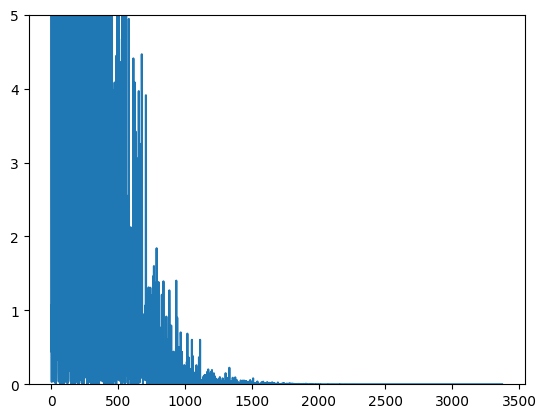

In [427]:
results = train_linear_model(100, 0.0, target_rtol=0.05, target_atol=0.0001, init_lr=0.01, max_steps=10000)
losses = results['loss']
time_to_val = results['time_to_val']
plt.plot(losses)
plt.ylim(0, 5)
print(time_to_val.median())

In [9]:
def train_dupe_feature_linear_model(
    n_inputs, 
    noise_strength,
    max_steps = 400000,
    target_rtol = 0.05,
    target_atol = 0.00001,
    meta_lr = 0.01,
    init_lr = 0.01,
    seed = None,
):
    """Run an experiment with a linear model that has duplicate noisy and non-noisy features."""
    if seed is not None:
        torch.manual_seed(seed)
    
    ### Prepare model and optimizer ###
    
    true_weights = torch.randn(1, n_inputs)
    model = torch.nn.Linear(n_inputs * 2, 1, bias=False)
    torch.nn.init.zeros_(model.weight)
    
    # Init noisy input weights as true values
    with torch.no_grad():
        model.weight.data[:, :n_inputs] = true_weights

    optimizer = IDBD(model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)

    ### Create inputs and targets ###

    true_inputs = torch.randint(0, 2, (max_steps, n_inputs,), dtype=torch.float)
    noisy_inputs = true_inputs + torch.randn(max_steps, n_inputs) * noise_strength
    full_inputs = torch.cat([noisy_inputs, true_inputs], dim=1)
    targets = true_inputs @ true_weights.T

    losses = []
    time_to_val = torch.inf * torch.ones(n_inputs, dtype=torch.float)
    time_to_pass = torch.inf * torch.ones(n_inputs, dtype=torch.float)
    
    for i, (input_val, target_val) in enumerate(zip(full_inputs, targets)):
        
        ### Train the model on a sample ###
        
        y_pred = model(input_val)
        loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target_val)
        losses.append(loss.item())

        param_inputs = {model.weight: input_val}
        optimizer.zero_grad()
        optimizer.step(loss, y_pred, param_inputs)
        
        ### Check which weights have reached their ideal value ###
        
        with torch.no_grad():
            # Find the weights that are close
            new_weights = model.weight.data[0, n_inputs:]
            weights_close = torch.isclose(true_weights[0], new_weights, rtol=target_rtol, atol=target_atol)
            new_time_to_val = torch.minimum(torch.full_like(time_to_val, i), time_to_val)
            time_to_val = torch.where(weights_close, new_time_to_val, time_to_val) # torch.inf)
            
            not_close_rtol = target_rtol * 2
            weights_not_close = ~torch.isclose(true_weights[0], new_weights, rtol=not_close_rtol, atol=target_atol)
            time_to_val = torch.where(weights_not_close, torch.inf, time_to_val)
        
            if not torch.isinf(time_to_val).any():
                break
            
        ### Check which weights have surpassed their counterparts ###
        
        with torch.no_grad():
            orig_weights = model.weight.data[0, :n_inputs]
            new_weights = model.weight.data[0, n_inputs:]
            
            weight_surpassed = torch.abs(new_weights) > torch.abs(orig_weights)
            new_time_to_pass = torch.minimum(torch.full_like(time_to_pass, i), time_to_pass)
            time_to_pass = torch.where(weight_surpassed, new_time_to_pass, torch.inf)
    
    return {
        'loss': losses,
        'time_to_val': time_to_val,
        'time_to_pass': time_to_pass,
    }

tensor(inf) tensor(7958.)


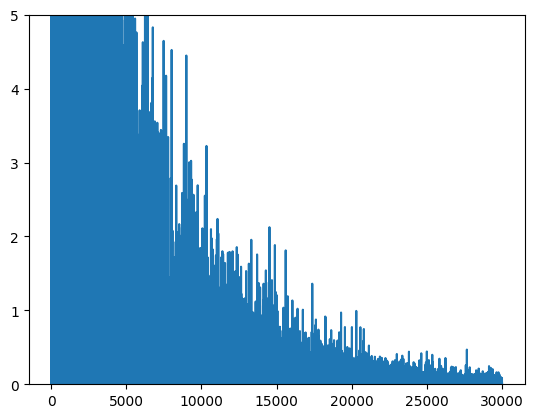

In [24]:
results = train_dupe_feature_linear_model(100, 0.2, target_rtol=0.05, target_atol=0.0001, init_lr=0.01, max_steps=30000, seed=1)
plt.plot(results['loss'])
plt.ylim(0, 5)
print(results['time_to_val'].median(), results['time_to_pass'].median())

In [ ]:
def train_individual_utilities_linear_model(
    n_inputs, 
    noise_strength,
    max_steps = 400000,
    target_rtol = 0.05,
    target_atol = 0.00001,
    meta_lr = 0.01,
    init_lr = 0.01,
    seed = None,
):
    """Run an experiment with a normal linear model."""
    if seed is not None:
        torch.manual_seed(seed)
    
    ### Prepare model and optimizer ###
    
    true_weights = torch.randn(1, n_inputs)
    model = torch.nn.Linear(n_inputs, 1, bias=False)
    torch.nn.init.zeros_(model.weight)
    
    utility_model = torch.nn.Linear(n_inputs, 1, bias=False)
    utility_bias = torch.nn.Parameter(torch.zeros(n_inputs, dtype=torch.float))
    torch.nn.init.zeros_(utility_model.weight)
    
    optimizer = IDBD(model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)
    utility_optimizer = torch.optim.SGD(list(utility_model.parameters()) + [utility_bias], lr=init_lr)

    ### Create inputs and targets ###

    true_inputs = torch.randint(0, 2, (max_steps, n_inputs,), dtype=torch.float)
    noisy_inputs = true_inputs + torch.randn(max_steps, n_inputs) * noise_strength
    targets = true_inputs @ true_weights.T

    losses = []
    time_to_val = torch.inf * torch.ones(n_inputs, dtype=torch.float)
    
    for i, (input_val, target_val) in enumerate(zip(noisy_inputs, targets)):
        
        ### Train the model on a sample ###
        
        y_pred = model(input_val)
        loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target_val)
        losses.append(loss.item())

        param_inputs = {model.weight: input_val}
        optimizer.zero_grad()
        optimizer.step(loss, y_pred, param_inputs)
        
        ### Train the utility model ###
        
        individual_preds = utility_model.weight.squeeze(dim=0) * input_val
        individual_preds += utility_bias
        utility_losses = (individual_preds - torch.full_like(individual_preds, target_val.item())) ** 2
        utility_losses = utility_losses.squeeze(dim=0)
        utility_loss = utility_losses.sum()
        
        utility_optimizer.zero_grad()
        utility_loss.backward()
        utility_optimizer.step()
        
        ### Check which weights have reached their ideal value ###
        
        with torch.no_grad():
            # Find the weights that are close
            utility_weights = utility_model.weight.data[0]
            weights_close = torch.isclose(true_weights[0], utility_weights, rtol=target_rtol, atol=target_atol)
            new_time_to_val = torch.minimum(torch.full_like(time_to_val, i), time_to_val)
            time_to_val = torch.where(weights_close, new_time_to_val, time_to_val) # torch.inf)
            
            not_close_rtol = target_rtol * 2
            weights_not_close = ~torch.isclose(true_weights[0], utility_weights, rtol=not_close_rtol, atol=target_atol)
            time_to_val = torch.where(weights_not_close, torch.inf, time_to_val)
        
            if not torch.isinf(time_to_val).any():
                break
    
    return {
        'loss': losses,
        'time_to_val': time_to_val,
        'true_weights': true_weights,
        'model_weights': model.weight.data[0],
        'utility_weights': utility_model.weight.data[0],
    }

tensor(892.)
tensor([[ 1.5410, -0.2934, -2.1788]])
tensor([ 1.5410, -0.2934, -2.1788])
tensor([ 1.4713, -0.1952, -2.1034])


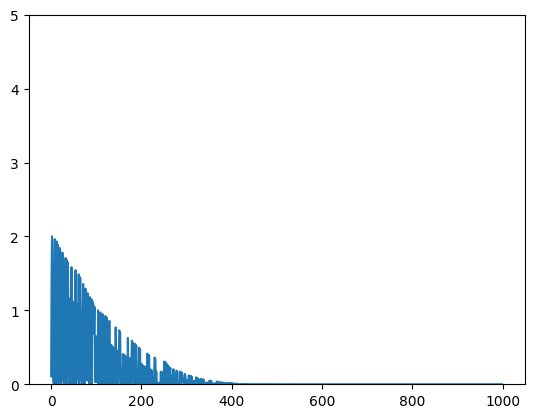

In [27]:
results = train_individual_utilities_linear_model(
    3, 0.0, target_rtol=0.05, target_atol=0.0001, init_lr=0.01, max_steps=1000)
losses = results['loss']
time_to_val = results['time_to_val']
plt.plot(losses)
plt.ylim(0, 5)
print(time_to_val.median())
print(results['true_weights'])
print(results['model_weights'])
print(results['utility_weights'])

In [333]:
def train_individual_utilities_difference_means(
    n_inputs, 
    noise_strength,
    max_steps = 400000,
    target_rtol = 0.05,
    target_atol = 0.00001,
    meta_lr = 0.01,
    init_lr = 0.01,
    seed = None,
):
    """Run an experiment with a normal linear model."""
    if seed is not None:
        torch.manual_seed(seed)
    
    ### Prepare model and optimizer ###
    
    true_weights = torch.randn(1, n_inputs)
    model = torch.nn.Linear(n_inputs, 1, bias=False)
    torch.nn.init.zeros_(model.weight)
    
    utility_model = torch.nn.Linear(n_inputs, 1, bias=False)
    torch.nn.init.zeros_(utility_model.weight)
    
    optimizer = IDBD(model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)
    # utility_optimizer = torch.optim.SGD(utility_model.parameters(), lr=init_lr)
    utility_optimizer = EnsembleIDBD(
        utility_model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)
    

    ### Create inputs and targets ###

    true_inputs = torch.randint(0, 2, (max_steps, n_inputs,), dtype=torch.float)
    noisy_inputs = true_inputs + torch.randn(max_steps, n_inputs) * noise_strength
    targets = true_inputs @ true_weights.T

    losses = []
    time_to_val = torch.inf * torch.ones(n_inputs, dtype=torch.float)
    
    prev_input_val = None
    prev_target_val = None
    
    for i, (input_val, target_val) in enumerate(zip(noisy_inputs, targets)):
        
        ### Train the model on a sample ###
        
        y_pred = model(input_val)
        loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target_val)
        losses.append(loss.item())

        param_inputs = {model.weight: input_val}
        optimizer.zero_grad()
        optimizer.step(loss, y_pred, param_inputs)
        
        ### Train the utility model ###
        
        if i > 0:
            utility_inputs = torch.ones_like(input_val)
            
            individual_targets = (target_val - prev_target_val) / (input_val - prev_input_val)
            valid_target_ids = torch.isfinite(individual_targets)
            individual_targets[~valid_target_ids] = 0.0
            individual_preds = utility_model.weight.squeeze(dim=0) * utility_inputs
            utility_losses = (individual_preds - individual_targets) ** 2
            utility_losses = torch.where(
                valid_target_ids,
                utility_losses,
                0.0,
            )
            
            # utility_loss = utility_losses.sum()
            # utility_optimizer.zero_grad()
            # utility_loss.backward()
            # utility_optimizer.step()
            
            param_inputs = {utility_model.weight: utility_inputs}
            utility_optimizer.zero_grad()
            utility_optimizer.step(utility_losses, individual_preds, param_inputs)
        
        ### Check which weights have reached their ideal value ###
        
        with torch.no_grad():
            # Find the weights that are close
            utility_weights = utility_model.weight.data[0]
            weights_close = torch.isclose(true_weights[0], utility_weights, rtol=target_rtol, atol=target_atol)
            new_time_to_val = torch.minimum(torch.full_like(time_to_val, i), time_to_val)
            time_to_val = torch.where(weights_close, new_time_to_val, time_to_val) # torch.inf)
            
            not_close_rtol = target_rtol * 2
            weights_not_close = ~torch.isclose(true_weights[0], utility_weights, rtol=not_close_rtol, atol=target_atol)
            time_to_val = torch.where(weights_not_close, torch.inf, time_to_val)
        
            if not torch.isinf(time_to_val).any():
                break
            
        prev_input_val = input_val
        prev_target_val = target_val
    
    return {
        'loss': losses,
        'time_to_val': time_to_val,
        'true_weights': true_weights,
        'model_weights': model.weight.data[0],
        'utility_weights': utility_model.weight.data[0],
    }

tensor(1578.)
tensor([[-0.6608,  0.1111,  0.4774, -0.6443, -0.9791]])
tensor([-0.6607,  0.1110,  0.4774, -0.6442, -0.9791])
tensor([-0.6747,  0.1149,  0.5063, -0.6467, -1.0173])


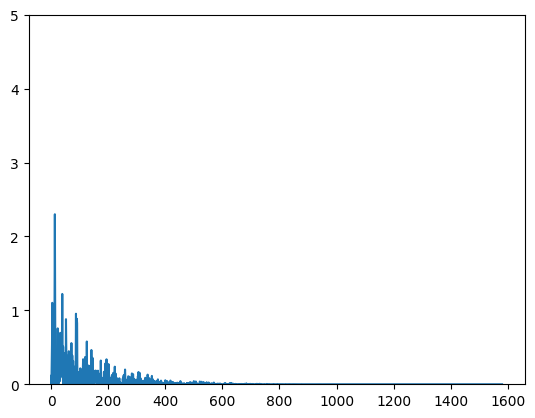

In [354]:
results = train_individual_utilities_difference_means(
    5, 0.0, target_rtol=0.05, target_atol=0.0001, init_lr=0.01, meta_lr=0.005, max_steps=10000)
losses = results['loss']
time_to_val = results['time_to_val']
plt.plot(losses)
plt.ylim(0, 5)
print(time_to_val.median())
print(results['true_weights'])
print(results['model_weights'])
print(results['utility_weights'])

In [355]:
print(time_to_val)

tensor([1578., 1580., 1577., 1580., 1464.])


In [5]:
def train_ensemble_linear_model(
    n_inputs, 
    noise_strength,
    max_steps = 400000,
    target_rtol = 0.05,
    target_atol = 0.00001,
    meta_lr = 0.01,
    init_lr = 0.01,
    ensemble_size = 3,
    seed = None,
    device = 'cuda',
):
    """Run an experiment with a linear model that has duplicate noisy and non-noisy features."""
    if seed is not None:
        torch.manual_seed(seed)
    
    ### Prepare model and optimizer ###
    
    true_weights = torch.randn(1, n_inputs).to(device)
    model = ParallelLinear(n_inputs * 2, 1, ensemble_size, bias=False).to(device)
    # model = torch.nn.Linear(n_inputs * 2, 1, bias=False)
    torch.nn.init.zeros_(model.weight)
    
    # Init noisy input weights as true values
    with torch.no_grad():
        model.weight.data[0, :, :n_inputs] = true_weights
    
        # Create sparsity masks for the ensemble
        weight_sparsity_mask = torch.ones_like(model.weight.data)
        weight_sparsity_mask[0, 0, n_inputs:] = 0.0
        n_features_per_layer = torch.randint(1, n_inputs * 2, (ensemble_size - 1,))
        for i, n_features in enumerate(n_features_per_layer):
            # Get random indices for this layer's features
            feature_indices = torch.randperm(n_inputs * 2)[:n_features]
            # Zero out all features except the randomly selected ones
            weight_sparsity_mask[i + 1, :, :] = 0.0
            weight_sparsity_mask[i + 1, 0, feature_indices] = 1.0

    # optimizer = IDBD(model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)
    # optimizer = torch.optim.SGD(model.parameters(), lr=init_lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

    ### Create inputs and targets ###

    true_inputs = torch.randint(0, 2, (max_steps, n_inputs,), dtype=torch.float).to(device)
    noisy_inputs = true_inputs + torch.randn(max_steps, n_inputs).to(device) * noise_strength
    full_inputs = torch.cat([noisy_inputs, true_inputs], dim=1)
    targets = true_inputs @ true_weights.T

    loss_history = []
    mse_loss_history = []
    time_to_val = torch.inf * torch.ones(n_inputs, dtype=torch.float).to(device)
    time_to_pass = torch.inf * torch.ones(n_inputs, dtype=torch.float).to(device)
    
    for i, (input_val, target_val) in enumerate(zip(full_inputs, targets)):
        
        ### Train the model on a sample ###
        
        y_preds = model(input_val)
        losses = 0.5 * (y_preds - target_val) ** 2 # [0.5 * torch.nn.functional.mse_loss(y_pred, target_val) for y_pred in y_preds]
        mse_loss = 0.5 * (y_preds.mean() - target_val) ** 2
        # loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target_val)
        loss = losses.sum()
        loss_history.append(loss.item())
        mse_loss_history.append(mse_loss.item())
        
        # param_inputs = {model.weight: input_val}
        # optimizer.zero_grad()
        # optimizer.step(loss, y_pred, param_inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.weight.data *= weight_sparsity_mask
        
        ### Check which weights have reached their ideal value ###
        
        with torch.no_grad():
            # Find the weights that are close
            new_weights = model.weight.data[1:, 0, n_inputs:].max(dim=0).values
            weights_close = torch.isclose(true_weights[0], new_weights, rtol=target_rtol, atol=target_atol)
            new_time_to_val = torch.minimum(torch.full_like(time_to_val, i), time_to_val)
            time_to_val = torch.where(weights_close, new_time_to_val, time_to_val) # torch.inf)
            
            not_close_rtol = target_rtol * 2
            weights_not_close = ~torch.isclose(true_weights[0], new_weights, rtol=not_close_rtol, atol=target_atol)
            time_to_val = torch.where(weights_not_close, torch.inf, time_to_val)
        
            if not torch.isinf(time_to_val).any():
                break
            
        ### Check which weights have surpassed their counterparts ###
        
        with torch.no_grad():
            orig_weights = model.weight.data[:, 0, :n_inputs].sum(dim=0) / weight_sparsity_mask[:, 0, :n_inputs].sum(dim=0)
            new_weights = model.weight.data[:, 0, n_inputs:].sum(dim=0) / weight_sparsity_mask[:, 0, n_inputs:].sum(dim=0)
            # new_weights = model.weight.data[1:, 0, n_inputs:].max(dim=0).values
            
            weight_surpassed = torch.abs(new_weights) > torch.abs(orig_weights)
            new_time_to_pass = torch.minimum(torch.full_like(time_to_pass, i), time_to_pass)
            time_to_pass = torch.where(weight_surpassed, new_time_to_pass, torch.inf)
    
    return {
        'loss': loss_history,
        'mse_loss': mse_loss_history,
        'time_to_val': time_to_val,
        'time_to_pass': time_to_pass,
        'true_weights': true_weights,
        'weights': model.weight.data,
    }

tensor(inf) tensor(987.)


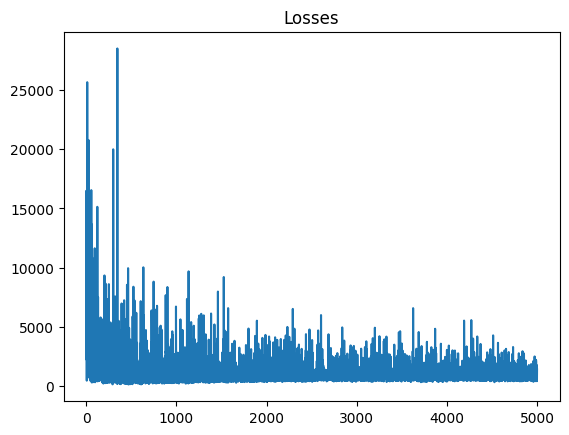

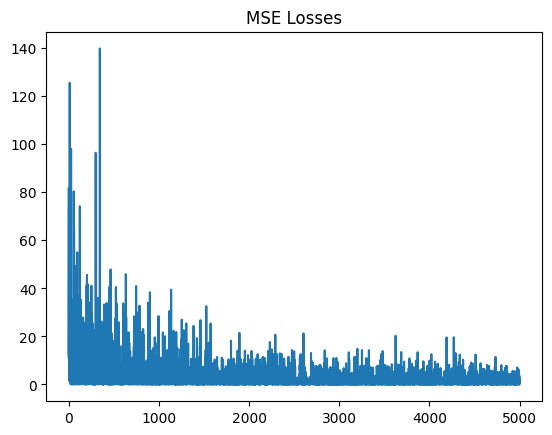

In [37]:
results = train_ensemble_linear_model(
    100, 0.2, target_rtol=0.05, target_atol=0.0001, init_lr=0.01,
    max_steps=5000, ensemble_size=200, device='cpu', seed=1,
)
print(results['time_to_val'].median(), results['time_to_pass'].median())

losses = results['loss']
mse_losses = results['mse_loss']

plt.plot(losses)
plt.title('Losses')
plt.show()

plt.plot(mse_losses)
plt.title('MSE Losses')
plt.show()

In [ ]:
def train_weighted_avg_ensemble_model(
    n_inputs, 
    noise_strength,
    max_steps = 400000,
    target_rtol = 0.05,
    target_atol = 0.00001,
    meta_lr = 0.01,
    init_lr = 0.01,
    ensemble_size = 3,
    seed = None,
    device = 'cuda',
):
    """Run an experiment with a linear model that has duplicate noisy and non-noisy features."""
    if seed is not None:
        torch.manual_seed(seed)
    
    ### Prepare model and optimizer ###
    
    true_weights = torch.randn(1, n_inputs).to(device)
    model = ParallelLinear(n_inputs * 2, 1, ensemble_size, bias=False).to(device)
    # model = torch.nn.Linear(n_inputs * 2, 1, bias=False)
    torch.nn.init.zeros_(model.weight)
    
    # Init noisy input weights as true values
    with torch.no_grad():
        model.weight.data[0, :, :n_inputs] = true_weights
    
        # Create sparsity masks for the ensemble
        weight_sparsity_mask = torch.ones_like(model.weight.data)
        weight_sparsity_mask[0, 0, n_inputs:] = 0.0
        n_features_per_layer = torch.randint(1, n_inputs * 2, (ensemble_size - 1,))
        for i, n_features in enumerate(n_features_per_layer):
            # Get random indices for this layer's features
            feature_indices = torch.randperm(n_inputs * 2)[:n_features]
            # Zero out all features except the randomly selected ones
            weight_sparsity_mask[i + 1, :, :] = 0.0
            weight_sparsity_mask[i + 1, 0, feature_indices] = 1.0

    # optimizer = IDBD(model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)
    # optimizer = torch.optim.SGD(model.parameters(), lr=init_lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

    ### Create inputs and targets ###

    true_inputs = torch.randint(0, 2, (max_steps, n_inputs,), dtype=torch.float).to(device)
    noisy_inputs = true_inputs + torch.randn(max_steps, n_inputs).to(device) * noise_strength
    full_inputs = torch.cat([noisy_inputs, true_inputs], dim=1)
    targets = true_inputs @ true_weights.T

    loss_history = []
    mse_loss_history = []
    time_to_val = torch.inf * torch.ones(n_inputs, dtype=torch.float).to(device)
    time_to_pass = torch.inf * torch.ones(n_inputs, dtype=torch.float).to(device)
    
    for i, (input_val, target_val) in enumerate(zip(full_inputs, targets)):
        
        ### Train the model on a sample ###
        
        y_preds = model(input_val)
        losses = 0.5 * (y_preds - target_val) ** 2 # [0.5 * torch.nn.functional.mse_loss(y_pred, target_val) for y_pred in y_preds]
        mse_loss = 0.5 * (y_preds.mean() - target_val) ** 2
        # loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target_val)
        loss = losses.sum()
        loss_history.append(loss.item())
        mse_loss_history.append(mse_loss.item())
        
        # param_inputs = {model.weight: input_val}
        # optimizer.zero_grad()
        # optimizer.step(loss, y_pred, param_inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.weight.data *= weight_sparsity_mask
        
        ### Check which weights have reached their ideal value ###
        
        with torch.no_grad():
            # Find the weights that are close
            new_weights = model.weight.data[1:, 0, n_inputs:].max(dim=0).values
            weights_close = torch.isclose(true_weights[0], new_weights, rtol=target_rtol, atol=target_atol)
            new_time_to_val = torch.minimum(torch.full_like(time_to_val, i), time_to_val)
            time_to_val = torch.where(weights_close, new_time_to_val, time_to_val) # torch.inf)
            
            not_close_rtol = target_rtol * 2
            weights_not_close = ~torch.isclose(true_weights[0], new_weights, rtol=not_close_rtol, atol=target_atol)
            time_to_val = torch.where(weights_not_close, torch.inf, time_to_val)
        
            if not torch.isinf(time_to_val).any():
                break
            
        ### Check which weights have surpassed their counterparts ###
        
        with torch.no_grad():
            orig_weights = model.weight.data[:, 0, :n_inputs].sum(dim=0) / weight_sparsity_mask[:, 0, :n_inputs].sum(dim=0)
            new_weights = model.weight.data[:, 0, n_inputs:].sum(dim=0) / weight_sparsity_mask[:, 0, n_inputs:].sum(dim=0)
            # new_weights = model.weight.data[1:, 0, n_inputs:].max(dim=0).values
            
            weight_surpassed = torch.abs(new_weights) > torch.abs(orig_weights)
            new_time_to_pass = torch.minimum(torch.full_like(time_to_pass, i), time_to_pass)
            time_to_pass = torch.where(weight_surpassed, new_time_to_pass, torch.inf)
    
    return {
        'loss': loss_history,
        'mse_loss': mse_loss_history,
        'time_to_val': time_to_val,
        'time_to_pass': time_to_pass,
        'true_weights': true_weights,
        'weights': model.weight.data,
    }

In [7]:
results['time_to_val'], results['time_to_pass']

(tensor([inf, inf, inf, inf, inf]), tensor([346., 131., 107., 538., 106.]))

In [422]:
results['true_weights']

tensor([[ 0.6525, -0.9531,  0.1170, -1.1556,  0.0807]])

In [423]:
results['weights']

tensor([[[ 0.6227, -0.9198,  0.0767, -1.1071,  0.0677, -0.0000,  0.0000,
          -0.0000,  0.0000, -0.0000]],

        [[ 0.2487, -0.0000, -0.0000, -1.3325, -0.0625,  0.2413, -0.0000,
          -0.1686, -0.0000,  0.0000]],

        [[ 0.0000, -0.0000, -0.0000, -0.0000,  0.0363,  0.0000, -0.0000,
           0.0000, -1.2810,  0.0585]],

        [[ 0.0000, -0.9308,  0.0367, -1.1092,  0.0218,  0.6399, -0.0000,
           0.0271, -0.0000,  0.0466]],

        [[ 0.6194, -0.9069,  0.0907, -0.5222,  0.0000, -0.0000, -0.0000,
          -0.0000, -0.6172,  0.0804]],

        [[ 0.6186, -0.9066,  0.0468, -0.5217,  0.0280, -0.0000, -0.0000,
           0.0415, -0.6169,  0.0518]],

        [[ 0.2911, -0.4309,  0.0593, -0.0000,  0.0332,  0.3509, -0.5103,
           0.0527, -1.1504,  0.0487]],

        [[ 0.2930, -0.4353,  0.0000, -0.5229,  0.0737,  0.3529, -0.5119,
           0.1016, -0.6147, -0.0000]],

        [[ 0.1927, -1.1984, -0.0515, -0.0000, -0.1136,  0.2419, -0.0000,
          -0.0818, -0.0